In [ ]:
# -*- coding: utf-8 -*-
"""
Created on 03/05/2017
@author: Luca Spadafora, Francesca Sivero, Nicola Picchiotti
@email: luca.spadafora@gmail.com
"""
import numpy as np
import copy
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as pl
import random


def local_volatility(ret, bandwidth):
    vol = np.zeros(ret.shape[0])
    for i in np.arange(bandwidth-1, ret.shape[0]):
        vol[i] = np.std(ret[i+1-bandwidth:i+1])
    vol[:bandwidth] = vol[bandwidth-1]
    return vol


def plot_local_vol(ret, vol):
    pl.figure()
    pl.plot(ret, '-b')
    pl.plot(vol, '-m')
    pl.plot(-vol, '-m')
    pl.xlabel = 'Time'
    pl.legend(['Returns', 'Volatility'])


def local_vol_order_stats(ret, bandwidth, prob_cut_off=0.05, max_iter=100):
    ju = np.zeros(ret.shape[0]).astype(bool)
    
    for iteration in range(max_iter):
        ju_old = copy.deepcopy(ju)
        vol = _thrLocalVol(ret, bandwidth, ju)
        ret_ren = (ret/vol).astype(np.double)
        ju = _getkJumpProb(ret_ren, ju, prob_cut_off)
        #Here we neglect jumps lower than volatility estimation as their size 
        #is inside the Gaussian region
        ju[np.abs(ret) < vol] = False
        if not((ju.shape[0] - np.sum(ju_old == ju) > 0)):
            break
    vol  = _thrLocalVol(ret, bandwidth, ju)
    return vol, ju


def _getkJumpProb(ret_ren, ju, prob_cut_off):
        
    ret_ren_indx = np.argsort(ret_ren)
    ret_sort = np.sort(ret_ren).astype(np.double)
    n = ret_ren.shape[0]
    k_gauss1 = 1
    k_gauss2 = 1
    n_1 = ret_ren.shape[0]
    #Here we neglect the center of the ret_ren array if the size is odd
    for k in np.arange(1, int(ret_ren.shape[0]*0.5)+1):
        if ju[ret_ren_indx[k-1]]:
            n_1 -= 1
        else:
            prob = _kSmallestCDF(ret_sort[k-1], k_gauss1, n_1)
            
            if prob <= prob_cut_off:
                ju[ret_ren_indx[k-1]] = True
                n_1 -= 1
            else:
                k_gauss1 += 1
            
        if ju[ret_ren_indx[n-k]]:
            n_1 -= 1
        else:
            prob = _kSmallestCDF(-ret_sort[n - k],k_gauss2,n_1)
            if prob <= prob_cut_off:
                ju[ret_ren_indx[n-k]] = True
                n_1 -= 1
            else:
                k_gauss2 += 1
            
    return ju


def _thrLocalVol(ret, bandwidth, ju):
    no_ju = 1. - ju
    vol = np.zeros(ret.shape[0])
    for i in np.arange(bandwidth-1, ret.shape[0]):
        ret_ = ret[i+1-bandwidth:i+1]*no_ju[i+1-bandwidth:i+1]
        vol[i] = np.sum(ret_**2.)/(np.sum(no_ju[i+1-bandwidth:i+1]))
        vol[i] = np.sqrt(vol[i])
    vol[:bandwidth] = vol[bandwidth-1]
    return vol


def _kSmallestCDF(x, k, n):
        y =  sp.betainc(np.double(k), n-np.double(k)+1., st.norm.cdf(x, 0., 1.))
        return y


def plot_local_vol_order_stat(ret, ju, vol):
    t = np.arange(0, ret.shape[0])
    pl.figure()
    pl.plot(t, ret, '-b')
    pl.plot(t[ju], ret[ju], 'ro')
    pl.plot(vol, '-m')
    pl.plot(-vol, '-m')
    pl.xlabel = 'Time'
    pl.legend(['Returns', 'Jumps', 'Volatility'])
    
    no_ju = (1. - ju).astype(bool)
    pl.figure()
    cdf = np.arange(1., ret.shape[0]+1.)/ret.shape[0]
    pl.plot(np.sort(ret)/np.std(ret), 1. - cdf, '-r.')
    cdf = np.arange(1., np.sum(no_ju)+1.)/np.sum(no_ju)
    pl.plot(np.sort(ret[no_ju]/vol[no_ju]), 1. - cdf, '-b.')
    min_ret = np.min(ret[no_ju]/vol[no_ju])
    x = np.arange(min_ret, -min_ret, -min_ret*0.001)
    pl.plot(x, 1.- st.norm.cdf(x, 0., 1.), '--k')
    pl.xlabel = 'Return'
    pl.ylabel = 'CDF'
    pl.legend(['Empirical (Renormalized)', 'Empirical (Ren. w/o jumps)', 'N(0,1)'])



NameError: name 'xrange' is not defined

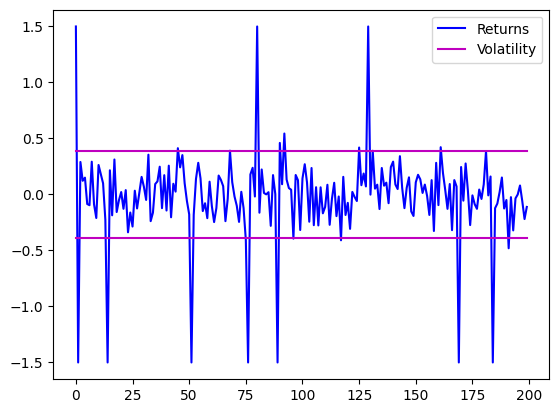

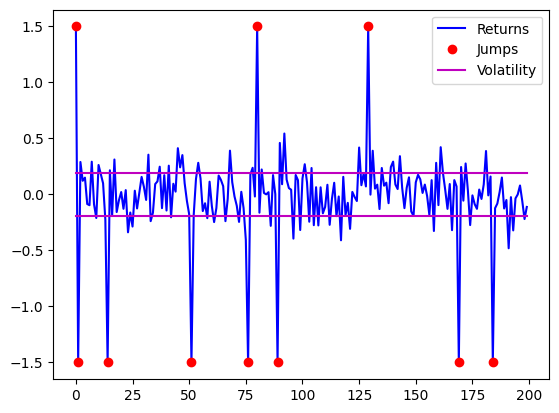

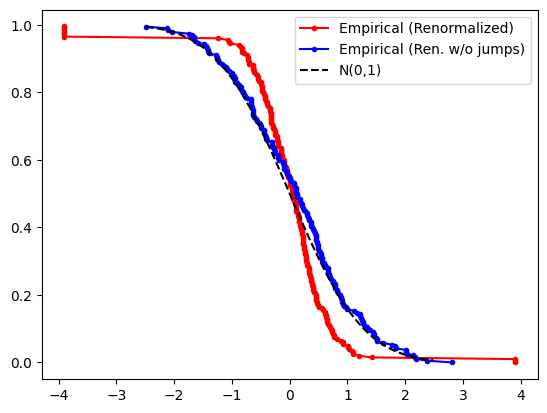

In [ ]:
if __name__ == '__main__':
    
    th_gauss_vol = 0.2
    jumps_percentage = 0.05
    jumps_size = 1.5
    array_size = 200
    bandwidth = 200
    ret = np.random.normal(0., th_gauss_vol, array_size)
    
    idx = random.sample(range(ret.shape[0]), int(ret.shape[0]*jumps_percentage))
    ret[idx] = np.sign(np.random.normal(0., 1., len(idx)))*jumps_size
    
    vol = local_volatility(ret, bandwidth)
    plot_local_vol(ret, vol)
    
    vol_os, ju = local_vol_order_stats(ret, bandwidth, prob_cut_off=0.05, max_iter=100)
    plot_local_vol_order_stat(ret, ju, vol_os)
   

In [5]:
 
    # print '*'*50
    print ('Theoretical Gaussian Volatility: ', th_gauss_vol)
    print ('Standard Volatility: ', vol[-1])
    print ('Order Statistics Volatility: ', vol_os[-1])
    # print '*'*50

Theoretical Gaussian Volatility:  0.2
Standard Volatility:  0.3843716945374884
Order Statistics Volatility:  0.1931788441165467
